# Thuật toán Ant Colony Optimization (ACO)

### Import thư viện 

In [1]:
# swarm algorithms imports
from swarm_algo.aco import AntColonyOptimizer as ACO
from swarm_algo.abc import ArtificialBeeColony as ABC
from swarm_algo.pso import ParticleSwarmOptimizer as PSO
from swarm_algo.firefly import Firefly as FA
from swarm_algo.cuckoo import CuckooSearch as CS

# traditional algorithms imports
from search_algo.genetic import GeneticAlgorithm as GA
from search_algo.bfs import BreadthFirstSearch as BFS
from search_algo.dfs import DepthFirstSearch as DFS

# problem imports
from problem.knapsack import Knapsack

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# utility imports
import random
import time
import logging
import os
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

In [2]:
TSP_DATA_FOLDER = "../data/tsp/"

In [3]:
def get_problem_infos(PROBLEM: int) -> Tuple[np.ndarray, List[int]]:
    """
    Load TSP problem data
    Returns:
        - distance_matrix: 2D array of distances between cities
        - solution: optimal solution path
    """
    problem = f"p{PROBLEM:02d}"

    # Read distance matrix
    with open(TSP_DATA_FOLDER + problem + "_d.txt") as f:
        lines = f.readlines()
        distance_matrix = []
        for line in lines:
            row = [float(x) for x in line.split()]
            distance_matrix.append(row)
        distance_matrix = np.array(distance_matrix)

    # Read solution path
    with open(TSP_DATA_FOLDER + problem + "_s.txt") as f:
        # Convert to 0-indexed
        solution = [int(s.strip()) - 1 for s in f.readlines()]

    return distance_matrix, solution

PROBLEM = 4
distance_matrix, solution = get_problem_infos(PROBLEM)
num_colonies = len(distance_matrix)
colonies = np.array([[i, 0] for i in range(num_colonies)])


# Phân tích chi tiết từng tham số 
Mỗi parameter sẽ được phân tích với 4 phần sau: 
1. Khả năng hội tụ 
2. Hiệu năng
3. Độ nhạy cảm của tham số
4. Biểu diễn mặt phẳng 3D (nếu có thể) 

## 1. Alpha: Độ quan trọng của Pheromone
Alpha điều khiển mức độ ảnh hưởng của pheromone trong quyết định của kiến. 
- alpha cao: Kiến tin tưởng nhiều vào pheromone (exploitation)
- alpha thấp: Kiến khám phá nhiều hơn (exploration)

### 1.1 Khả năng hội tụ 

In [9]:
alpha_configs = [
    {'alpha': 0.5, 'label': 'alpha=0.5'},
    {'alpha': 1.0, 'label': 'alpha=1.0'},
    {'alpha': 2.0, 'label': 'alpha=2.0'},
    {'alpha': 3.0, 'label': 'alpha=3.0'},
    {'alpha': 3.5, 'label': 'alpha=3.5'},
    {'alpha': 4.0, 'label': 'alpha=4.0'},

]

alpha_conv_results = []
for config in alpha_configs:
    print(f"\nChạy với {config['label']}...")
    aco = ACO(colonies, num_ant=20, iter=100, 
                            alpha=config['alpha'], beta=2.0, rho=0.5, Q=100)
    best_path, best_fitness = aco.run(verbose=False)
    alpha_conv_results.append({
        'config': config,
        'best_fitness': best_fitness,
        'best_history': aco.best_fitness_history,
        'avg_history': aco.avg_fitness_history,
        'diversity': aco.diversity_history
    })
    print(f"   Best fitness: {best_fitness:.2f}")




Chạy với alpha=0.5...
   Best fitness: 94.00

Chạy với alpha=1.0...
   Best fitness: 94.00

Chạy với alpha=2.0...
   Best fitness: 94.00

Chạy với alpha=3.0...
   Best fitness: 94.00

Chạy với alpha=3.5...
   Best fitness: 94.00

Chạy với alpha=4.0...
   Best fitness: 94.00


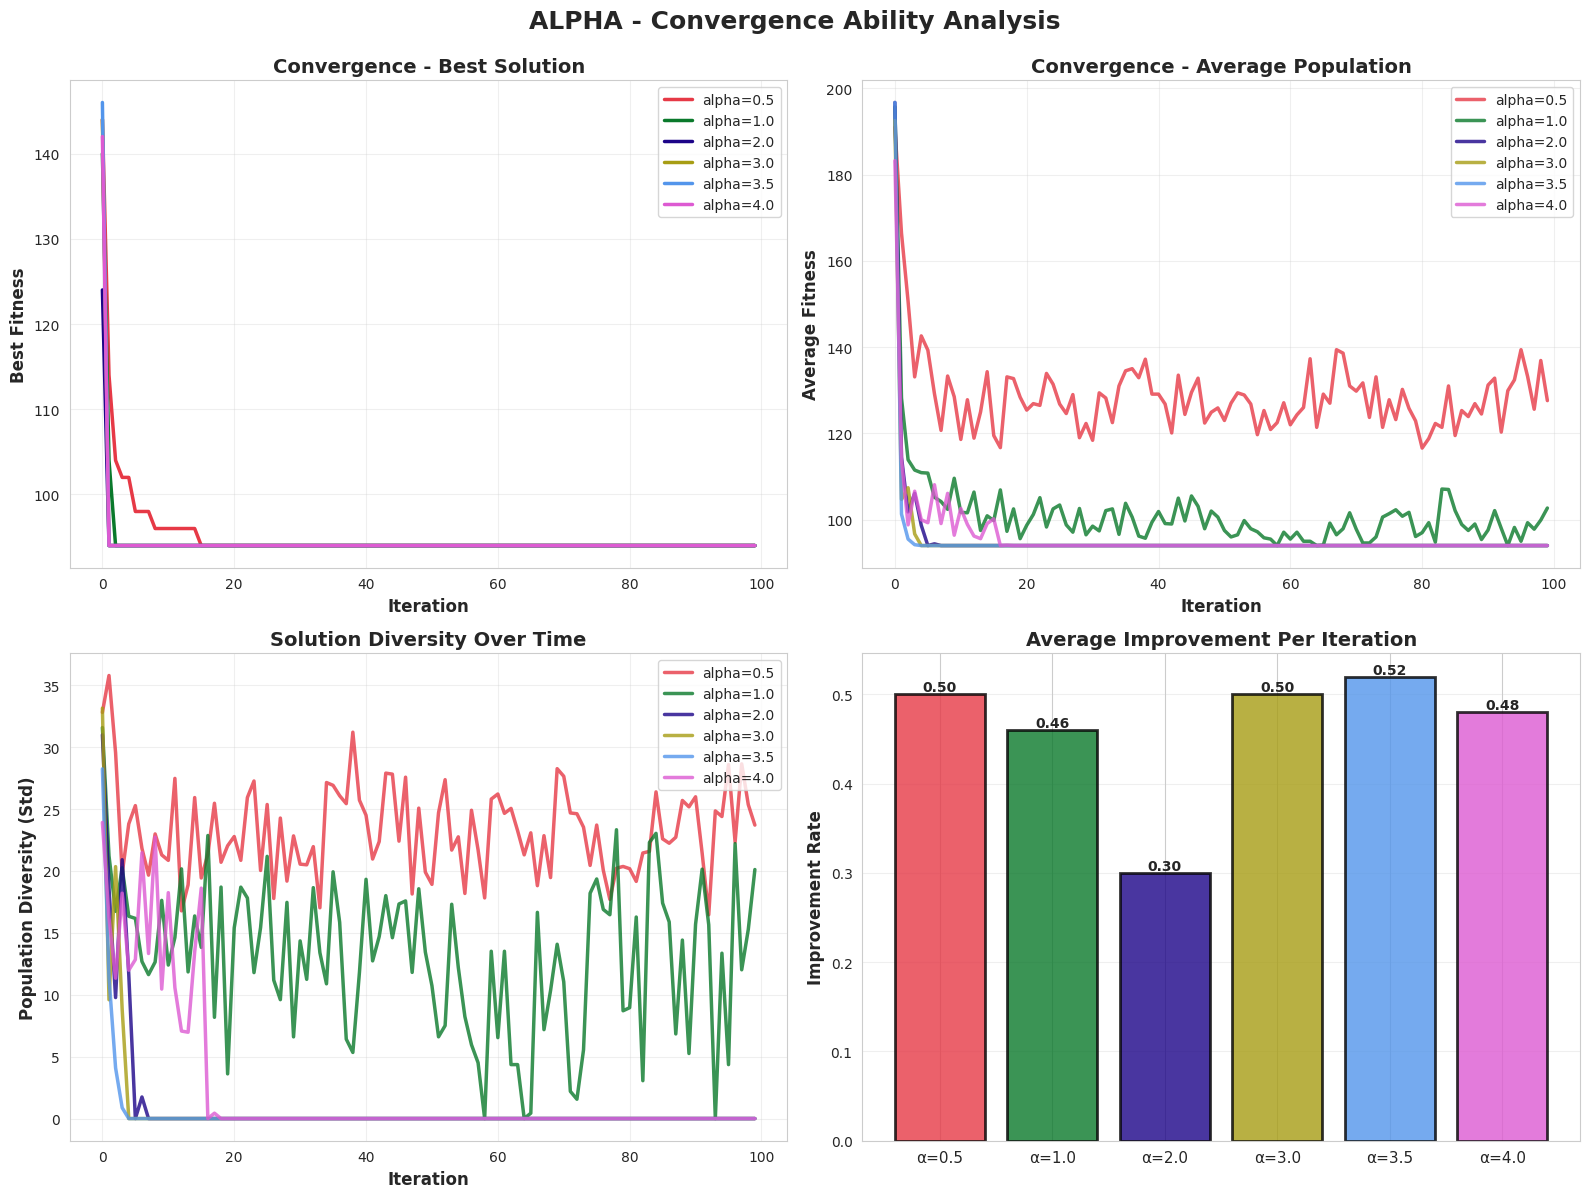

In [12]:
# Vẽ Convergence
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = ['#E63946', "#0A792B", "#1C0488", "#A79D14","#5395EB","#DD5AD2"]

# Best fitness
ax1 = axes[0, 0]
for r, color in zip(alpha_conv_results, colors):
    ax1.plot(r['best_history'], label=r['config']['label'], 
            linewidth=2.5, color=color)
ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Best Fitness', fontsize=12, fontweight='bold')
ax1.set_title('Convergence - Best Solution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Average fitness
ax2 = axes[0, 1]
for r, color in zip(alpha_conv_results, colors):
    ax2.plot(r['avg_history'], label=r['config']['label'], 
            linewidth=2.5, color=color, alpha=0.8)
ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Fitness', fontsize=12, fontweight='bold')
ax2.set_title('Convergence - Average Population', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Diversity
ax3 = axes[1, 0]
for r, color in zip(alpha_conv_results, colors):
    ax3.plot(r['diversity'], label=r['config']['label'], 
            linewidth=2.5, color=color, alpha=0.8)
ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax3.set_ylabel('Population Diversity (Std)', fontsize=12, fontweight='bold')
ax3.set_title('Solution Diversity Over Time', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Convergence rate
ax4 = axes[1, 1]
improvement_rates = []
labels = []
for r in alpha_conv_results:
    history = r['best_history']
    rate = (history[0] - history[-1]) / len(history)
    improvement_rates.append(rate)
    labels.append(f"α={r['config']['alpha']}")

bars = ax4.bar(range(len(labels)), improvement_rates, color=colors, 
              alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_xticks(range(len(labels)))
ax4.set_xticklabels(labels, fontsize=11)
ax4.set_ylabel('Improvement Rate', fontsize=12, fontweight='bold')
ax4.set_title('Average Improvement Per Iteration', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, improvement_rates):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('ALPHA - Convergence Ability Analysis', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('alpha_1_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



### 1.2 So sánh hiệu suất

In [13]:
# Tính toán các chỉ số
best_fits = [r['best_fitness'] for r in alpha_conv_results]
conv_speeds = []
stabilities = []
final_diversities = []

for r in alpha_conv_results:
    history = r['best_history']
    final = history[-1]
    target = final * 1.05
    try:
        conv_iter = next(i for i, v in enumerate(history) if v <= target)
    except StopIteration:
        conv_iter = len(history)
    conv_speeds.append(conv_iter)
    stabilities.append(np.std(history[-20:]))
    final_diversities.append(r['diversity'][-1])


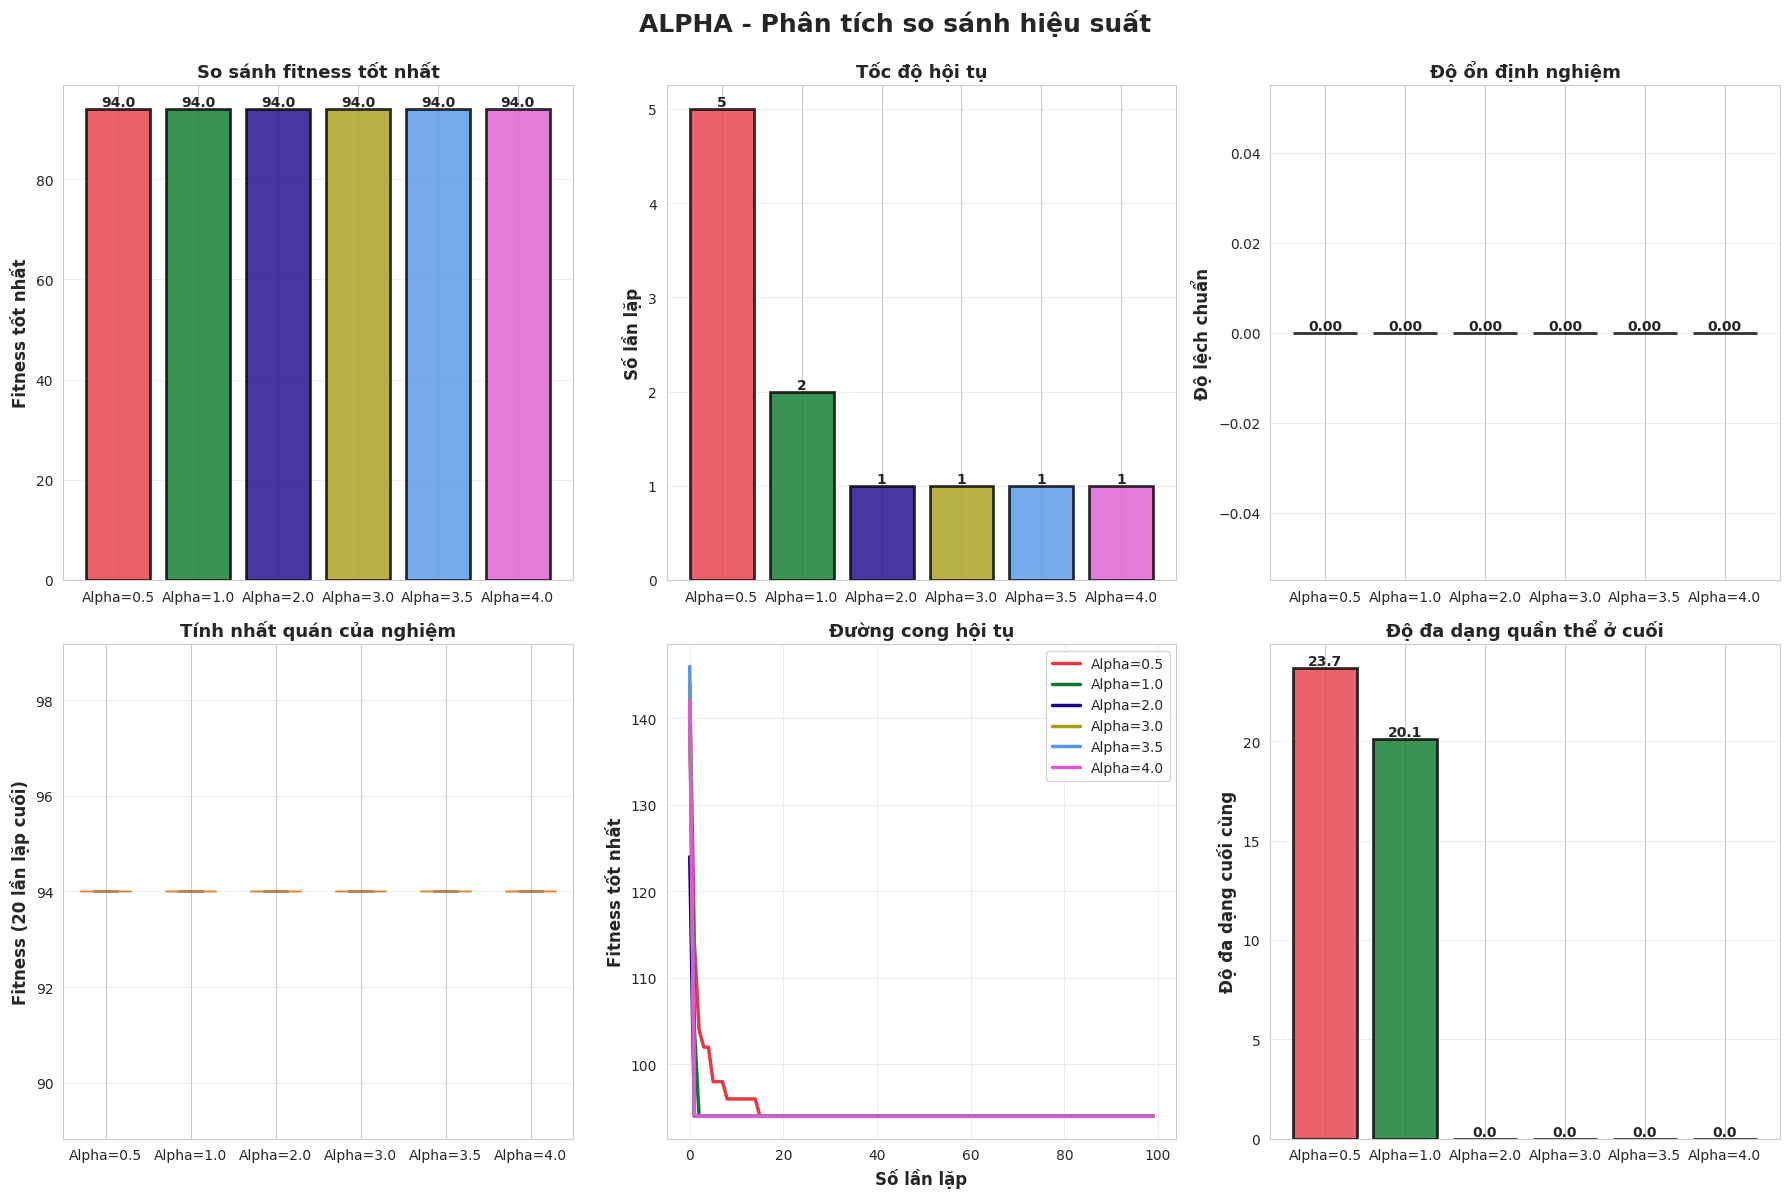

Đã tạo biểu đồ so sánh hiệu suất cho Alpha


In [ ]:
# Vẽ biểu đồ so sánh hiệu suất
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
labels_short = [f"Alpha={r['config']['alpha']}" for r in alpha_conv_results]

# 1. So sánh fitness tốt nhất
ax1 = axes[0, 0]
bars = ax1.bar(range(len(labels_short)), best_fits, color=colors, 
              alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(labels_short)))
ax1.set_xticklabels(labels_short)
ax1.set_ylabel('Fitness tốt nhất', fontsize=12, fontweight='bold')
ax1.set_title('So sánh fitness tốt nhất', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, best_fits):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Tốc độ hội tụ
ax2 = axes[0, 1]
bars = ax2.bar(range(len(labels_short)), conv_speeds, color=colors, 
              alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(labels_short)))
ax2.set_xticklabels(labels_short)
ax2.set_ylabel('Số lần lặp', fontsize=12, fontweight='bold')
ax2.set_title('Tốc độ hội tụ', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, conv_speeds):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{int(val)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Độ ổn định
ax3 = axes[0, 2]
bars = ax3.bar(range(len(labels_short)), stabilities, color=colors, 
              alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_xticks(range(len(labels_short)))
ax3.set_xticklabels(labels_short)
ax3.set_ylabel('Độ lệch chuẩn', fontsize=12, fontweight='bold')
ax3.set_title('Độ ổn định nghiệm', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, stabilities):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Biểu đồ hộp
ax4 = axes[1, 0]
last_20_data = [r['best_history'][-20:] for r in alpha_conv_results]
bp = ax4.boxplot(last_20_data, labels=labels_short, patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('Fitness (20 lần lặp cuối)', fontsize=12, fontweight='bold')
ax4.set_title('Tính nhất quán của nghiệm', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Đường hội tụ
ax5 = axes[1, 1]
for r, color in zip(alpha_conv_results, colors):
    ax5.plot(r['best_history'], label=f"Alpha={r['config']['alpha']}", 
            linewidth=2.5, color=color)
ax5.set_xlabel('Số lần lặp', fontsize=12, fontweight='bold')
ax5.set_ylabel('Fitness tốt nhất', fontsize=12, fontweight='bold')
ax5.set_title('Đường cong hội tụ', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. Độ đa dạng cuối cùng
ax6 = axes[1, 2]
bars = ax6.bar(range(len(labels_short)), final_diversities, color=colors, 
              alpha=0.8, edgecolor='black', linewidth=2)
ax6.set_xticks(range(len(labels_short)))
ax6.set_xticklabels(labels_short)
ax6.set_ylabel('Độ đa dạng cuối cùng', fontsize=12, fontweight='bold')
ax6.set_title('Độ đa dạng quần thể ở cuối', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, final_diversities):
    ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('ALPHA - Phân tích so sánh hiệu suất', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('alpha_2_so_sanh_hieu_suat.png', dpi=300, bbox_inches='tight')
plt.show()



### 1.3 Độ nhạy tham số

In [16]:
alpha_values = [0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
alpha_sens_results = []

for alpha in alpha_values:
    aco = ACO(colonies, num_ant=20, iter=80, alpha=alpha, 
                            beta=2.0, rho=0.5, Q=100)
    best_path, best_fitness = aco.run(verbose=False)
    alpha_sens_results.append({
        'alpha': alpha,
        'best_fitness': best_fitness,
        'history': aco.best_fitness_history
    })



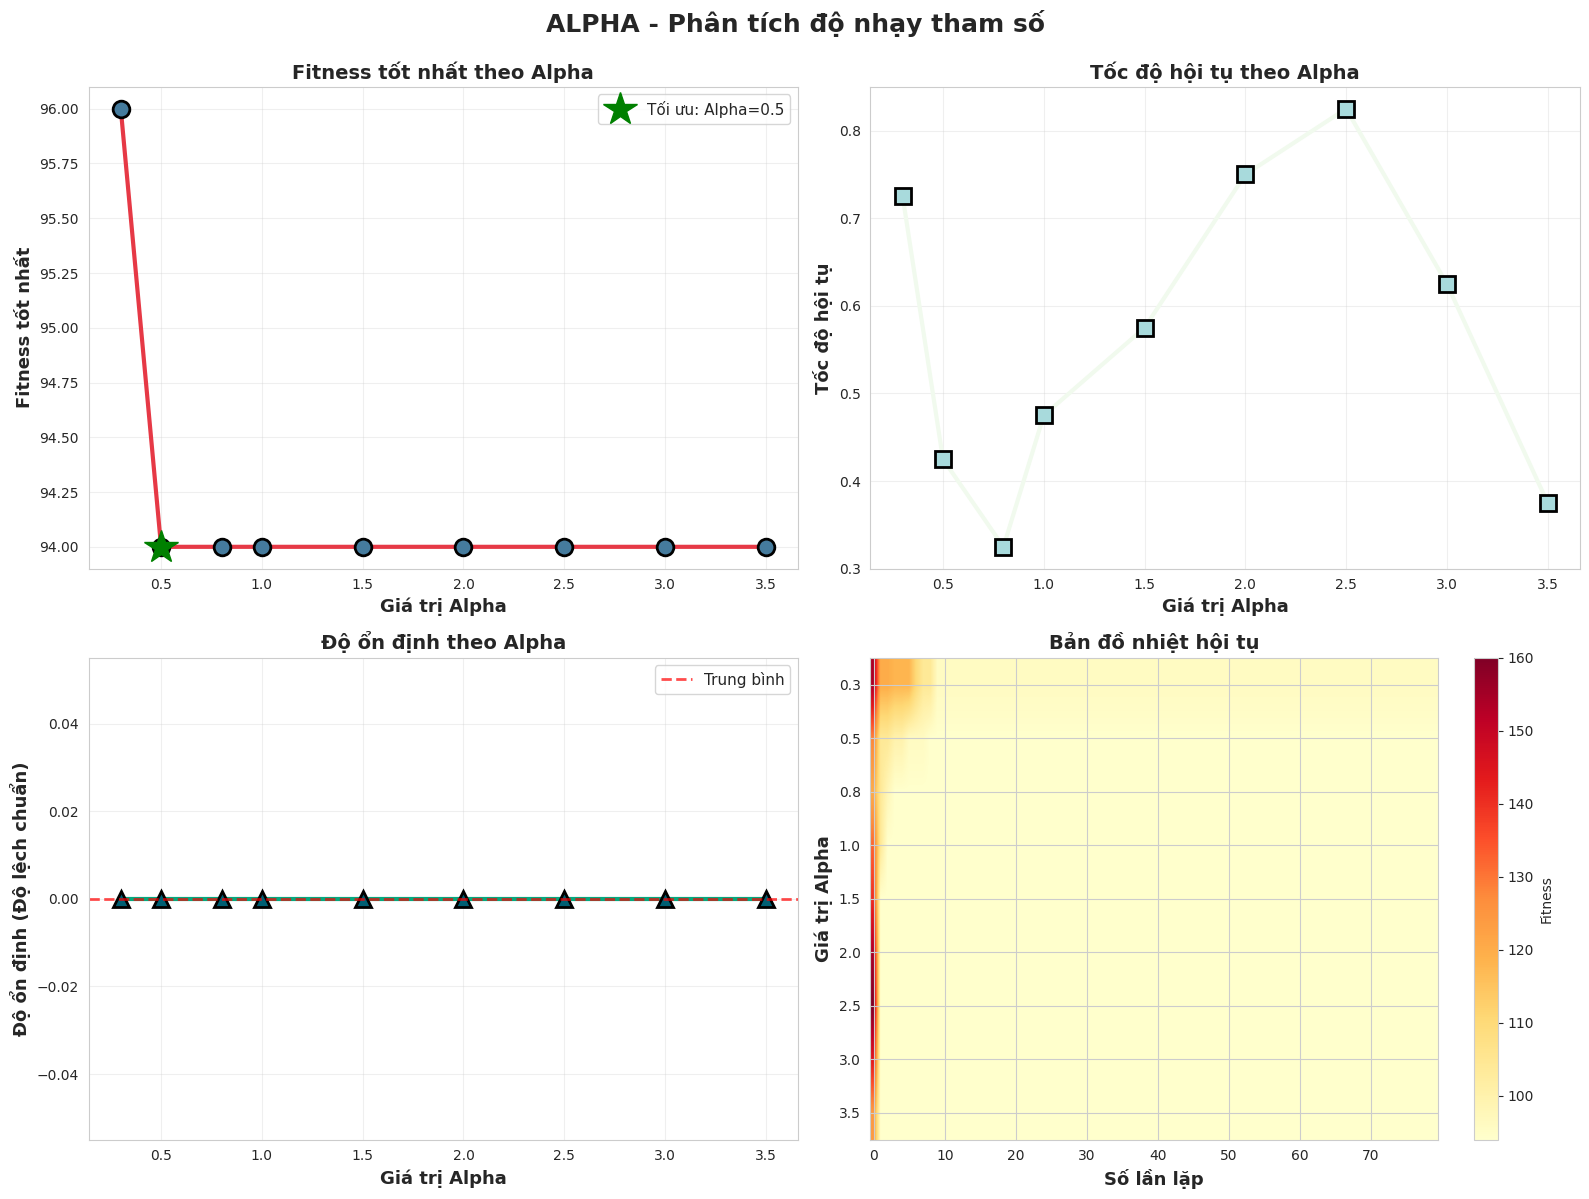

In [18]:
# Tính toán các chỉ số
sens_alpha_vals = [r['alpha'] for r in alpha_sens_results]
sens_best_fits = [r['best_fitness'] for r in alpha_sens_results]
sens_conv_rates = []
sens_stabilities = []

for r in alpha_sens_results:
    history = r['history']
    rate = (history[0] - history[-1]) / len(history) if len(history) > 1 else 0
    sens_conv_rates.append(rate)
    sens_stabilities.append(np.std(history[-20:]))

# Vẽ biểu đồ độ nhạy
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Fitness tốt nhất theo alpha
ax1 = axes[0, 0]
ax1.plot(sens_alpha_vals, sens_best_fits, 'o-', linewidth=3, markersize=12,
        color='#E63946', markerfacecolor='#457B9D', markeredgewidth=2, markeredgecolor='black')
optimal_idx = np.argmin(sens_best_fits)
ax1.plot(sens_alpha_vals[optimal_idx], sens_best_fits[optimal_idx],
        'g*', markersize=25, label=f'Tối ưu: Alpha={sens_alpha_vals[optimal_idx]:.1f}', zorder=5)
ax1.set_xlabel('Giá trị Alpha', fontsize=13, fontweight='bold')
ax1.set_ylabel('Fitness tốt nhất', fontsize=13, fontweight='bold')
ax1.set_title('Fitness tốt nhất theo Alpha', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Tốc độ hội tụ
ax2 = axes[0, 1]
ax2.plot(sens_alpha_vals, sens_conv_rates, 's-', linewidth=3, markersize=12,
        color='#F1FAEE', markerfacecolor='#A8DADC', markeredgewidth=2, markeredgecolor='black')
ax2.set_xlabel('Giá trị Alpha', fontsize=13, fontweight='bold')
ax2.set_ylabel('Tốc độ hội tụ', fontsize=13, fontweight='bold')
ax2.set_title('Tốc độ hội tụ theo Alpha', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Độ ổn định
ax3 = axes[1, 0]
ax3.plot(sens_alpha_vals, sens_stabilities, '^-', linewidth=3, markersize=12,
        color='#06A77D', markerfacecolor='#005F73', markeredgewidth=2, markeredgecolor='black')
ax3.axhline(y=np.mean(sens_stabilities), color='r', linestyle='--', 
           linewidth=2, alpha=0.7, label='Trung bình')
ax3.set_xlabel('Giá trị Alpha', fontsize=13, fontweight='bold')
ax3.set_ylabel('Độ ổn định (Độ lệch chuẩn)', fontsize=13, fontweight='bold')
ax3.set_title('Độ ổn định theo Alpha', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Bản đồ nhiệt hội tụ
ax4 = axes[1, 1]
max_len = max(len(r['history']) for r in alpha_sens_results)
heatmap_data = []
for r in alpha_sens_results:
    history = r['history']
    if len(history) < max_len:
        x_old = np.linspace(0, 1, len(history))
        x_new = np.linspace(0, 1, max_len)
        history = np.interp(x_new, x_old, history)
    heatmap_data.append(history)

heatmap_data = np.array(heatmap_data)
im = ax4.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', interpolation='bilinear')
ax4.set_xlabel('Số lần lặp', fontsize=13, fontweight='bold')
ax4.set_ylabel('Giá trị Alpha', fontsize=13, fontweight='bold')
ax4.set_yticks(range(len(sens_alpha_vals)))
ax4.set_yticklabels([f'{v:.1f}' for v in sens_alpha_vals])
ax4.set_title('Bản đồ nhiệt hội tụ', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax4, label='Fitness')

plt.suptitle('ALPHA - Phân tích độ nhạy tham số', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('alpha_3_do_nhay_tham_so.png', dpi=300, bbox_inches='tight')
plt.show()


### 1.4 Biểu diễn mặt phẳng 3D

In [20]:
alpha_range = np.linspace(0.5, 3.0, 8)
beta_range = np.linspace(0.5, 3.0, 8)
fitness_grid = np.zeros((len(alpha_range), len(beta_range)))

total = len(alpha_range) * len(beta_range)
count = 0
for i, alpha in enumerate(alpha_range):
    for j, beta in enumerate(beta_range):
        count += 1
        aco = ACO(colonies, num_ant=20, iter=60, 
                                alpha=alpha, beta=beta, rho=0.5, Q=100)
        _, best_fitness = aco.run(verbose=False)
        fitness_grid[i, j] = best_fitness
        if count % 8 == 0:
            print(f"Tiến độ: {count}/{total} ({100*count/total:.0f}%)")

Tiến độ: 8/64 (12%)
Tiến độ: 16/64 (25%)
Tiến độ: 24/64 (38%)
Tiến độ: 32/64 (50%)
Tiến độ: 40/64 (62%)
Tiến độ: 48/64 (75%)
Tiến độ: 56/64 (88%)
Tiến độ: 64/64 (100%)


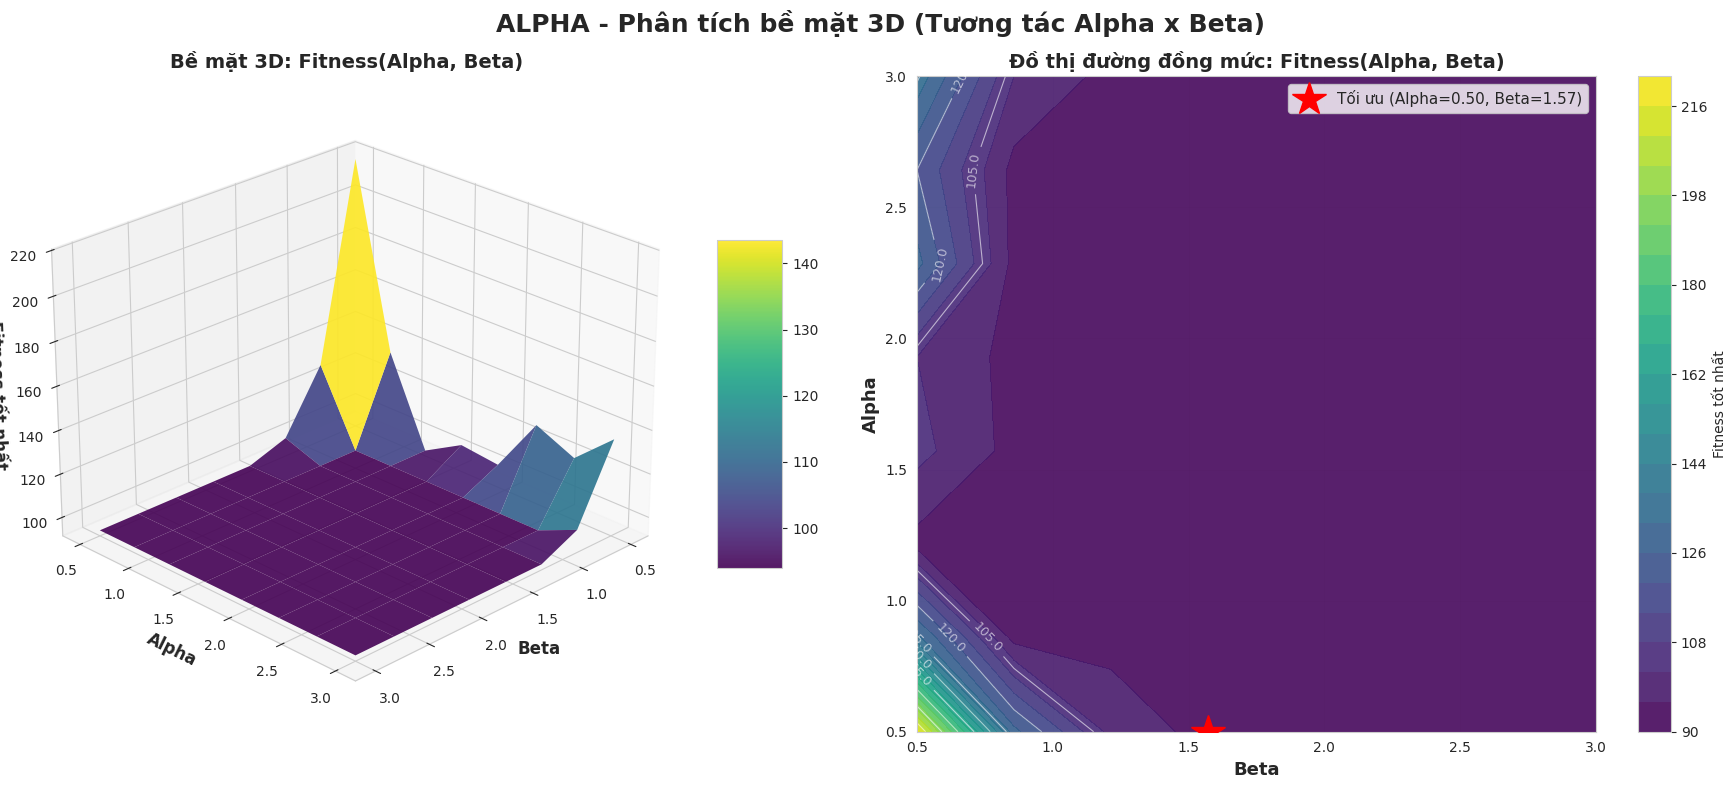

Đã tạo biểu đồ bề mặt 3D cho Alpha


In [21]:
# Vẽ bề mặt 3D
fig = plt.figure(figsize=(18, 8))

# Bề mặt 3D
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(beta_range, alpha_range)
surf = ax1.plot_surface(X, Y, fitness_grid, cmap='viridis', alpha=0.9,
                       antialiased=True, edgecolor='none')
ax1.set_xlabel('Beta', fontsize=12, fontweight='bold')
ax1.set_ylabel('Alpha', fontsize=12, fontweight='bold')
ax1.set_zlabel('Fitness tốt nhất', fontsize=12, fontweight='bold')
ax1.set_title('Bề mặt 3D: Fitness(Alpha, Beta)', fontsize=14, fontweight='bold')
ax1.view_init(elev=25, azim=45)
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

# Đồ thị đường đồng mức
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, fitness_grid, levels=20, cmap='viridis', alpha=0.9)
contour_lines = ax2.contour(X, Y, fitness_grid, levels=10, colors='white',
                            linewidths=0.8, alpha=0.6)
ax2.clabel(contour_lines, inline=True, fontsize=9, fmt='%.1f')
ax2.set_xlabel('Beta', fontsize=13, fontweight='bold')
ax2.set_ylabel('Alpha', fontsize=13, fontweight='bold')
ax2.set_title('Đồ thị đường đồng mức: Fitness(Alpha, Beta)', fontsize=14, fontweight='bold')
fig.colorbar(contour, ax=ax2, label='Fitness tốt nhất')

# Đánh dấu điểm tối ưu
min_idx = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)
opt_alpha = alpha_range[min_idx[0]]
opt_beta = beta_range[min_idx[1]]
ax2.plot(opt_beta, opt_alpha, 'r*', markersize=25, 
        label=f'Tối ưu (Alpha={opt_alpha:.2f}, Beta={opt_beta:.2f})', zorder=5)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)

plt.suptitle('ALPHA - Phân tích bề mặt 3D (Tương tác Alpha x Beta)', 
            fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('alpha_4_be_mat_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã tạo biểu đồ bề mặt 3D cho Alpha")